In [1]:
import music21
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import mnet
from scipy import stats

## Load Data

In [2]:
'''
Creat local corpus with access pieces
'''

localCorpus = music21.corpus.corpora.LocalCorpus()
localCorpus.addPath('../library')
music21.corpus.cacheMetadata()


/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: local metadata cache: starting processing of paths: 1
/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/j6/2q7hftds7vb8_lsfy50l8lzw0000gn/T/music21/local.p.gz
bundles.py: WARNING: MetadataBundle Modification Time: 1589085342.9675808
bundles.py: WARNING: Skipped 1 sources already in cache.
/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: writing time: 0.018 md items: 6

/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/j6/2q7hftds7vb8_lsfy50l8lzw0000gn/T/music21/local.p.gz
caching.py: WARNING: cache: final writing time: 0.018 seconds


In [3]:
def change_weight_analysis(g_group, datapoints=20, dist=1):
    transition_vars =[]
    transition_means = []
    for transition in transition_edges:


        i=0
        varlist=np.zeros(datapoints)
        meanlist=np.zeros(datapoints)
        while i < datapoints*dist:
            print(i)
            g = g_group.copy()
            g = mnet.degree_increase(g, [transition], i)
            l = mnet.get_Lengths(g, 1000)
            index=int(i/dist)
            print(index)
            varlist[index] = (np.std(l))
            meanlist[index] = (np.mean(l))
            i += dist
        transition_vars.append(varlist)
        transition_means.append(meanlist)
        print(meanlist)
        print(varlist)
    return transition_vars, transition_means


In [4]:
def community_freq_analysis(g_rn, community_nodeDictionary, node_communityDictionary, iterations = 50):
    
    sections = list(community_nodeDictionary.keys())
    
    freq_arr = np.zeros(( iterations, len(sections)))
    time_arr = np.zeros(( iterations, len(sections)))
    length_arr = np.zeros(iterations)
    
    #Run 50 random walks
    i = 0
    while i < iterations:
        

        
        randomwalk=mnet.generate_randomwalk(g_rn)
        melody_list, community_lst= mnet.str_rn_annotated(randomwalk, node_communityDictionary)

        #Get frequency of each section
        orderlst = np.array(mnet.getComOrder(community_lst))
        section_freq = mnet.countQuantity(orderlst, sections)
        freq_arr[i]=section_freq
        
        #Get time spent in each section
        time_per_section = mnet.countQuantity(np.array(community_lst), sections)
        time_arr[i] = time_per_section
        #print(time_per_section)
        
        #Get Length
        length_arr[i]=len(community_lst)
        
        i += 1
        
    freq_average = np.sum(freq_arr, axis=0)/iterations
    freq_margin_of_error = 2* stats.sem(freq_arr)
    
    time_average = np.sum(time_arr, axis=0)/iterations
    time_margin_of_error = 2* stats.sem(time_arr)



    return [sections, freq_average, freq_margin_of_error], [sections, time_average, time_margin_of_error], length_arr


## Roman Numeral 

In [5]:

s = music21.corpus.parse('telemannfantasie1.xml')
chord_lst = list(s.chordify().recurse().notes)
nodelst = mnet.convert_chord_note(chord_lst, 'A')
g_rn=mnet.create_graph(nodelst)

#write as .gexf
#nx.write_gexf(g_rn, "rn_composition_notechord.gexf")


## Clustering

Infomap analysis done in web app

In [6]:

g_info = mnet.convert_to_weighted(g_rn, fraction=False)

#Node to community dictionary
bigDict = {}
smallDict = {}
with open("../graphs/rn.net.tree") as tree:
    for line in tree:
        spl = line.split('"')
        node = spl[1]
        path = spl[0].split(':')
        bigGroup=path[0]
        smallGroup=path[0]+path[1]
        #print(node, bigGroup, smallGroup)
        bigDict[node]=bigGroup
        smallDict[node]=smallGroup
        
        
nx.set_node_attributes(g_info, bigDict, 'bigGroup')
nx.set_node_attributes(g_info, smallDict, 'smallGroup')
#nx.write_gexf(g_info, "../graphs/rn_info.gexf")


#community to Node dictionaries + list of subgraphs
c1, sglst1= mnet.generateCommunities(bigDict, g_info)

c2, sglst2 = mnet.generateCommunities(smallDict, g_info)

## Analyze Original Graph

In [7]:
section_freq_graph_big, section_time_graph_big, len_arr_big = community_freq_analysis(g_rn, c1, bigDict, 500)
section_freq_graph_small, section_time_graph_small, len_arr_small = community_freq_analysis(g_rn, c2, smallDict, 500)



/Users/kaitlinpet/Desktop/Coursework/networks/project/notebooks/mnet.py:529: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  quantitylst.append(np.count_nonzero(orderlst == s))


# Strengthen Edges Between Large Communities

In [8]:
bridge12, bridge21 = mnet.findBridges(g_info, c1['1'], c1['2'])

In [9]:
bridge13, bridge31 = mnet.findBridges(g_info, c1['1'], c1['3'])

See fraction of traffic leaving each node

In [10]:
g_fraction=mnet.convert_to_weighted(g_rn, fraction= True)

Notes for Paper

In [11]:
for el in bridge12:
    print(el, g_fraction.get_edge_data(el[0], el[1])['weight'])

('G4 I', 'D5 IV') 0.5
('A4 Ib753', 'G3 I') 0.3333333333333333


In [12]:
for el in bridge13:
    print(el, g_fraction.get_edge_data(el[0], el[1])['weight'])    

('A4 I', 'E5 V') 0.020833333333333332


Alter Graph

In [13]:
g_rn1 = g_rn.copy()
g_rn1 = mnet.degree_increase(g_rn1, bridge13, 20)
g_rn1 = mnet.degree_increase(g_rn1, bridge12, 20)

In [14]:
g_fraction1=mnet.convert_to_weighted(g_rn1, fraction= True)

In [15]:
for el in bridge13:
    print(el, g_fraction1.get_edge_data(el[0], el[1])['weight'])  

('A4 I', 'E5 V') 0.3088235294117647


In [16]:
for el in bridge12:
    print(el, g_fraction1.get_edge_data(el[0], el[1])['weight'])  

('G4 I', 'D5 IV') 0.9545454545454546
('A4 Ib753', 'G3 I') 0.9130434782608695


### Analysis of Strengthening Connections Between Large Groups

Analyze Community List - done on random walk

In [17]:
section_freq_graph1, section_time_graph1, len_arr1 = community_freq_analysis(g_rn1, c1, bigDict, 500)

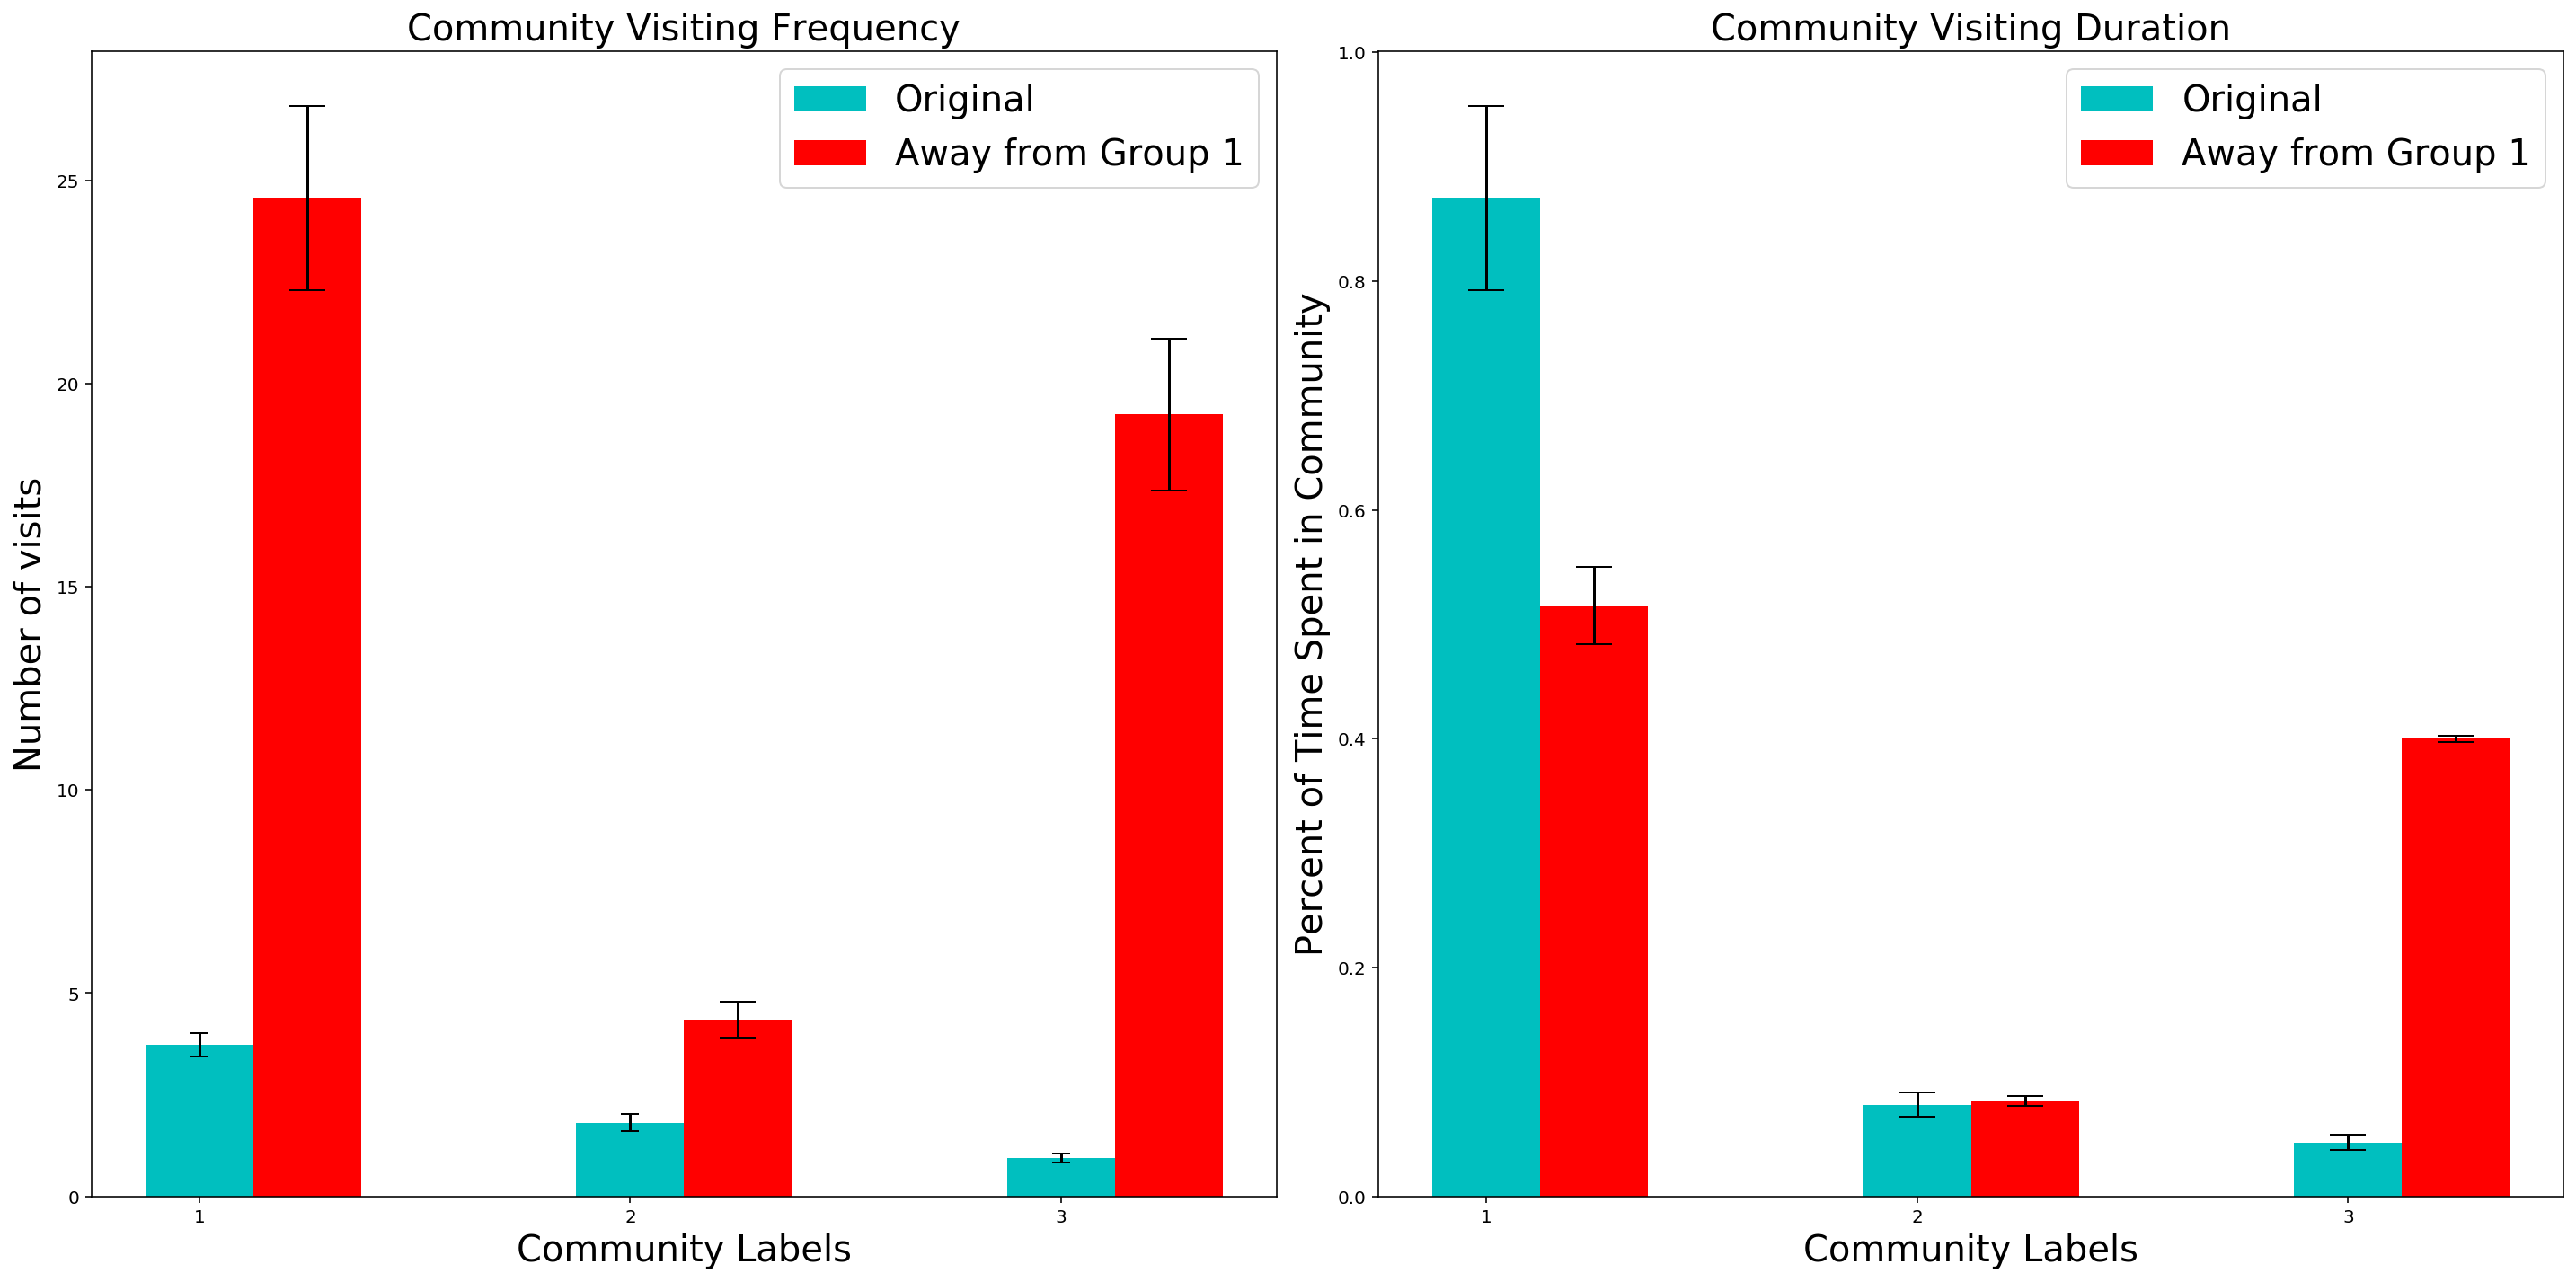

In [41]:
#Make Big Plot



fig = plt.figure(figsize=(20, 10))

ax0 = plt.subplot2grid((1,2), (0,0))

ax0.set_title("Community Visiting Frequency", fontsize=20)
ax0.set_xlabel("Community Labels", fontsize=20)
ax0.set_ylabel("Number of visits", fontsize=20)
#ax = fig.add_axes([0,0,1,1])


cat = section_freq_graph1[0]
i=0
while i < len(cat):
    cat[i]= int(cat[i])
    i += 1
cat = np.array(cat)

freq_og = section_freq_graph_big[1]
og_err = section_freq_graph_big[2]


freq_comp1 = section_freq_graph1[1]
err_1 = section_freq_graph1[2]

#ax = fig.add_axes([0,0,1,1])
ax0.bar(cat + 0.00, freq_og, color = 'c', yerr=og_err, width = 0.25, label = "Original", capsize=5)
ax0.bar(cat + 0.25, freq_comp1, color = 'r',yerr=err_1, capsize=10, width = 0.25, label = "Away from Group 1")
ax0.legend(fontsize=20)
#ax.set_ylim((0,1))
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax0.get_xaxis().set_ticks([1,2,3])

ax = plt.subplot2grid((1,2), (0,1))

ax.set_title("Community Visiting Duration", fontsize=20)
ax.set_xlabel("Community Labels", fontsize=20)
ax.set_ylabel("Percent of Time Spent in Community", fontsize=20)
#ax = fig.add_axes([0,0,1,1])

cat = section_time_graph1[0]
i=0
while i < len(cat):
    cat[i]= int(cat[i])
    i += 1
cat = np.array(cat)
time_og = section_time_graph_big[1]/np.sum(section_time_graph_big[1])
time_err_og = section_time_graph_big[2]/np.sum(section_time_graph_big[1])

time_comp1 = section_time_graph1[1]/np.sum(section_time_graph1[1])
time_err1 = section_time_graph_big[2]/np.sum(section_time_graph1[1])

#ax = fig.add_axes([0,0,1,1])
ax.bar(cat + 0.00, time_og, color = 'c', width = 0.25, label = "Original", yerr=time_err_og, capsize=10)
ax.bar(cat + 0.25, time_comp1, color = 'r', width = 0.25, label = "Away from Group 1", yerr=time_err1, capsize=10)
ax.legend(fontsize=20)
#ax.set_ylim((0,1))
ax.get_xaxis().set_ticks([1,2,3])
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
plt.savefig("../figures/rn_change_large_community_travel.pdf")
plt.tight_layout()


## Strengthen Sequences

In [19]:
g_rn2 = g_rn.copy()

Sequences usually have 1 less edge than nodes

In [20]:
for subgraph in sglst2:
    if len(list(subgraph.nodes())) - 1 == len(list(subgraph.edges())):
        for node in list(subgraph.nodes):
            if len(list(subgraph.predecessors(node))) == 0: #entrance node
                preds = g_rn2.predecessors(node)
                prededgelst=[]
                for p in preds:
                    prededgelst.append((p, node))
                g_rn2 = mnet.degree_increase(g_rn2, prededgelst, 10)
                    
                
        

In [21]:
section_freq_graph2, section_time_graph2, len_arr2 = community_freq_analysis(g_rn2, c2, smallDict, 500)

## Strengthen Non - Sequences

In [22]:
g_rn3 = g_rn.copy()

In [23]:
for subgraph in sglst2:
    if len(list(subgraph.nodes())) - 1 != len(list(subgraph.edges())):
        #print("found")
        for node in list(subgraph.nodes):

            if len(list(subgraph.predecessors(node))) != len(list(g_rn3.predecessors(node))): #entrance node
                preds = set(g_rn3.predecessors(node)) - set(subgraph.predecessors(node))
                prededgelst=[]
                for p in preds:
                    prededgelst.append((p, node))
                g_rn3 = mnet.degree_increase(g_rn3, prededgelst, 10)
                #print("edges added")
                #print(prededgelst)
                    
                
        

In [24]:
section_freq_graph3, section_time_graph3, len_arr3 = community_freq_analysis(g_rn3, c2, smallDict, 500)

## Increase Probability of Staying in Level 2 Community

In [25]:
g_rn5 = g_rn.copy()

In [26]:
for subgraph in sglst2:
    g_rn5 = mnet.degree_increase(g_rn5, list(subgraph.edges()), 10)


In [27]:
section_freq_graph5, section_time_graph5, len_arr5 = community_freq_analysis(g_rn5, c2, smallDict, 500)

['11', '12', '13', '14', '15', '16', '17', '18', '19', '110', '111', '112', '113', '114', '115', '116', '117', '118', '21', '22', '23', '24', '31', '32']


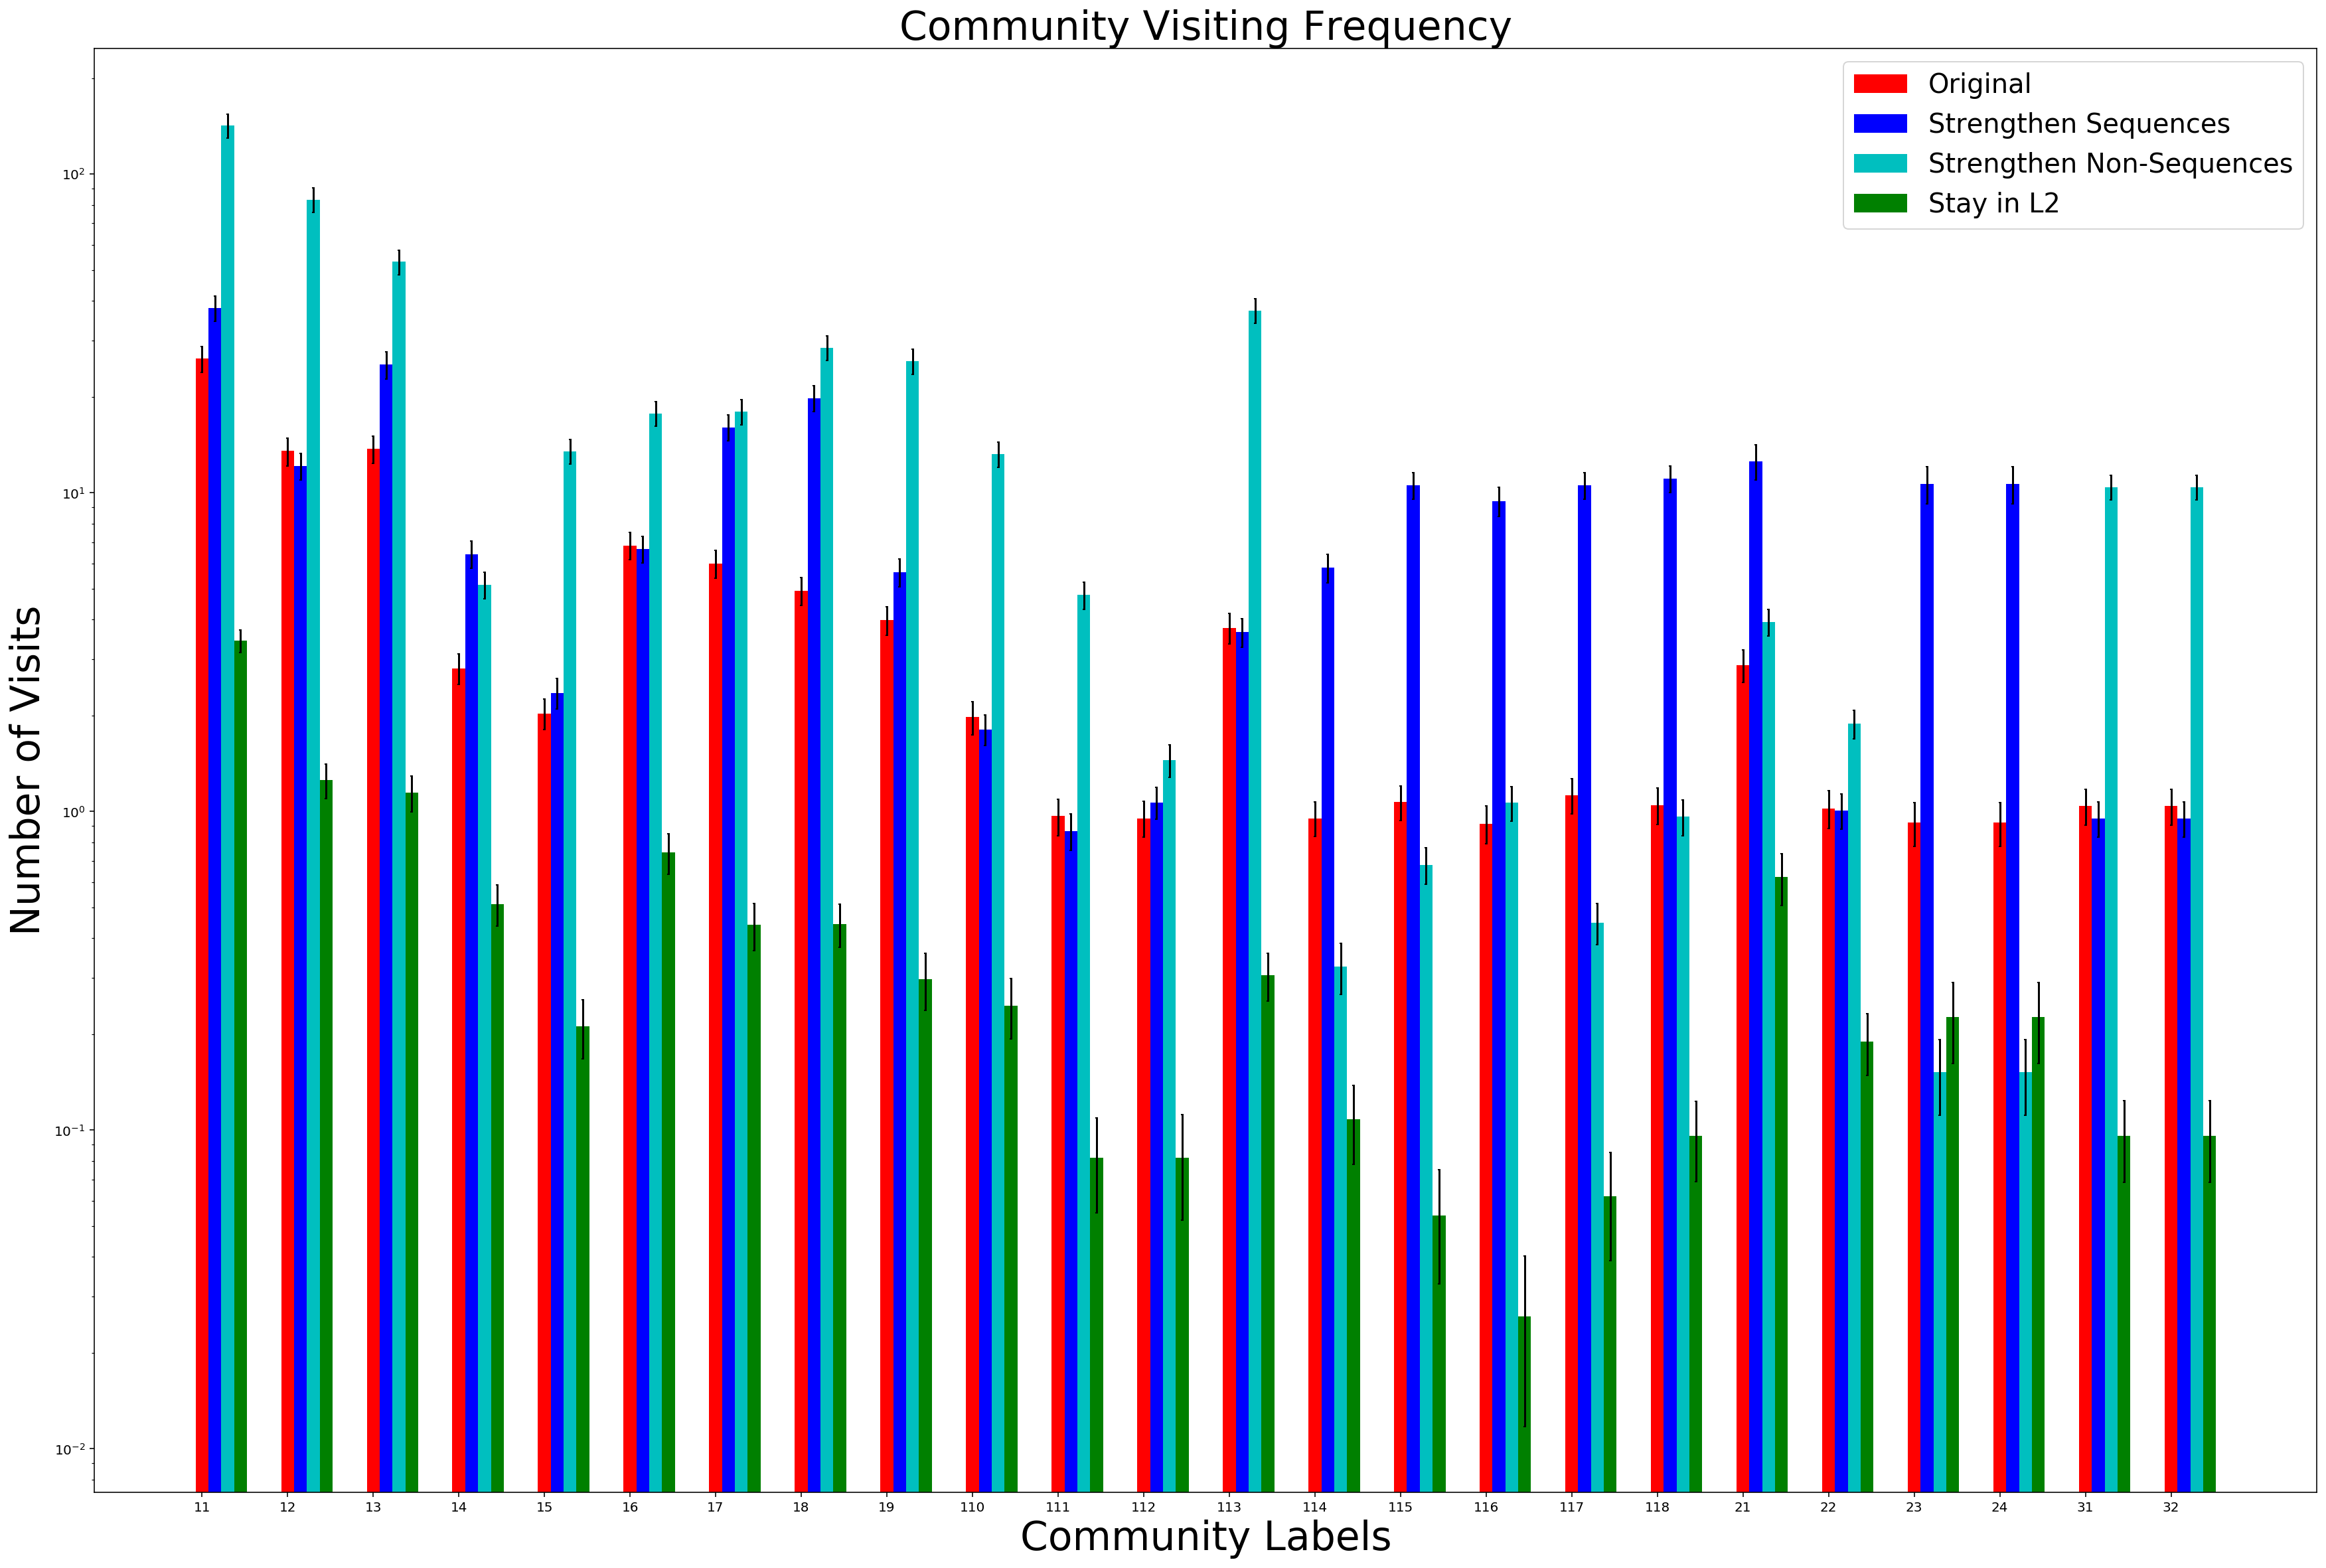

In [42]:
fig, ax = plt.subplots(figsize=(30,20))
ax.set_title("Community Visiting Frequency", fontsize=30)
ax.set_xlabel("Community Labels", fontsize=30)
ax.set_ylabel("Number of Visits", fontsize=30)
#ax = fig.add_axes([0,0,1,1])


cat = section_freq_graph2[0]
print(cat)
x = np.arange(len(cat))
ax.set_xticks(x)
ax.set_xticklabels(cat)

freq_og_small = section_freq_graph_small[1]#/np.sum(section_freq_graph_small[1])
freq_og_small_err = section_freq_graph_small[2]

freq_comp2 = section_freq_graph2[1]#/np.sum(section_freq_graph2[1])
freq_comp_2_err = section_freq_graph2[2]

freq_comp3 = section_freq_graph3[1]#/np.sum(section_freq_graph3[1])
freq_comp_3_err = section_freq_graph3[2]

freq_comp5 = section_freq_graph5[1]#/np.sum(section_freq_graph5[1])
freq_comp_5_err = section_freq_graph5[2]

#ax = fig.add_axes([0,0,1,1])
ax.bar(x + 0.00, freq_og_small, color = 'r', width = 0.15, label = "Original", yerr = freq_og_small_err, capsize=1)
ax.bar(x + 0.15, freq_comp2, color = 'b', width = 0.15, label = "Strengthen Sequences", yerr = freq_comp_2_err, capsize=1)
ax.bar(x + 0.30, freq_comp3, color = 'c', width = 0.15, label = "Strengthen Non-Sequences", yerr = freq_comp_3_err, capsize=1)
ax.bar(x + 0.45, freq_comp5, color = 'g', width = 0.15, label = "Stay in L2", yerr = freq_comp_5_err, capsize=1)
ax.legend(fontsize=20)
ax.set_yscale('log')
#ax.set_ylim((0,1))
plt.savefig("../figures/rn_freqdiff_smallcom.pdf")

['11', '12', '13', '14', '15', '16', '17', '18', '19', '110', '111', '112', '113', '114', '115', '116', '117', '118', '21', '22', '23', '24', '31', '32']


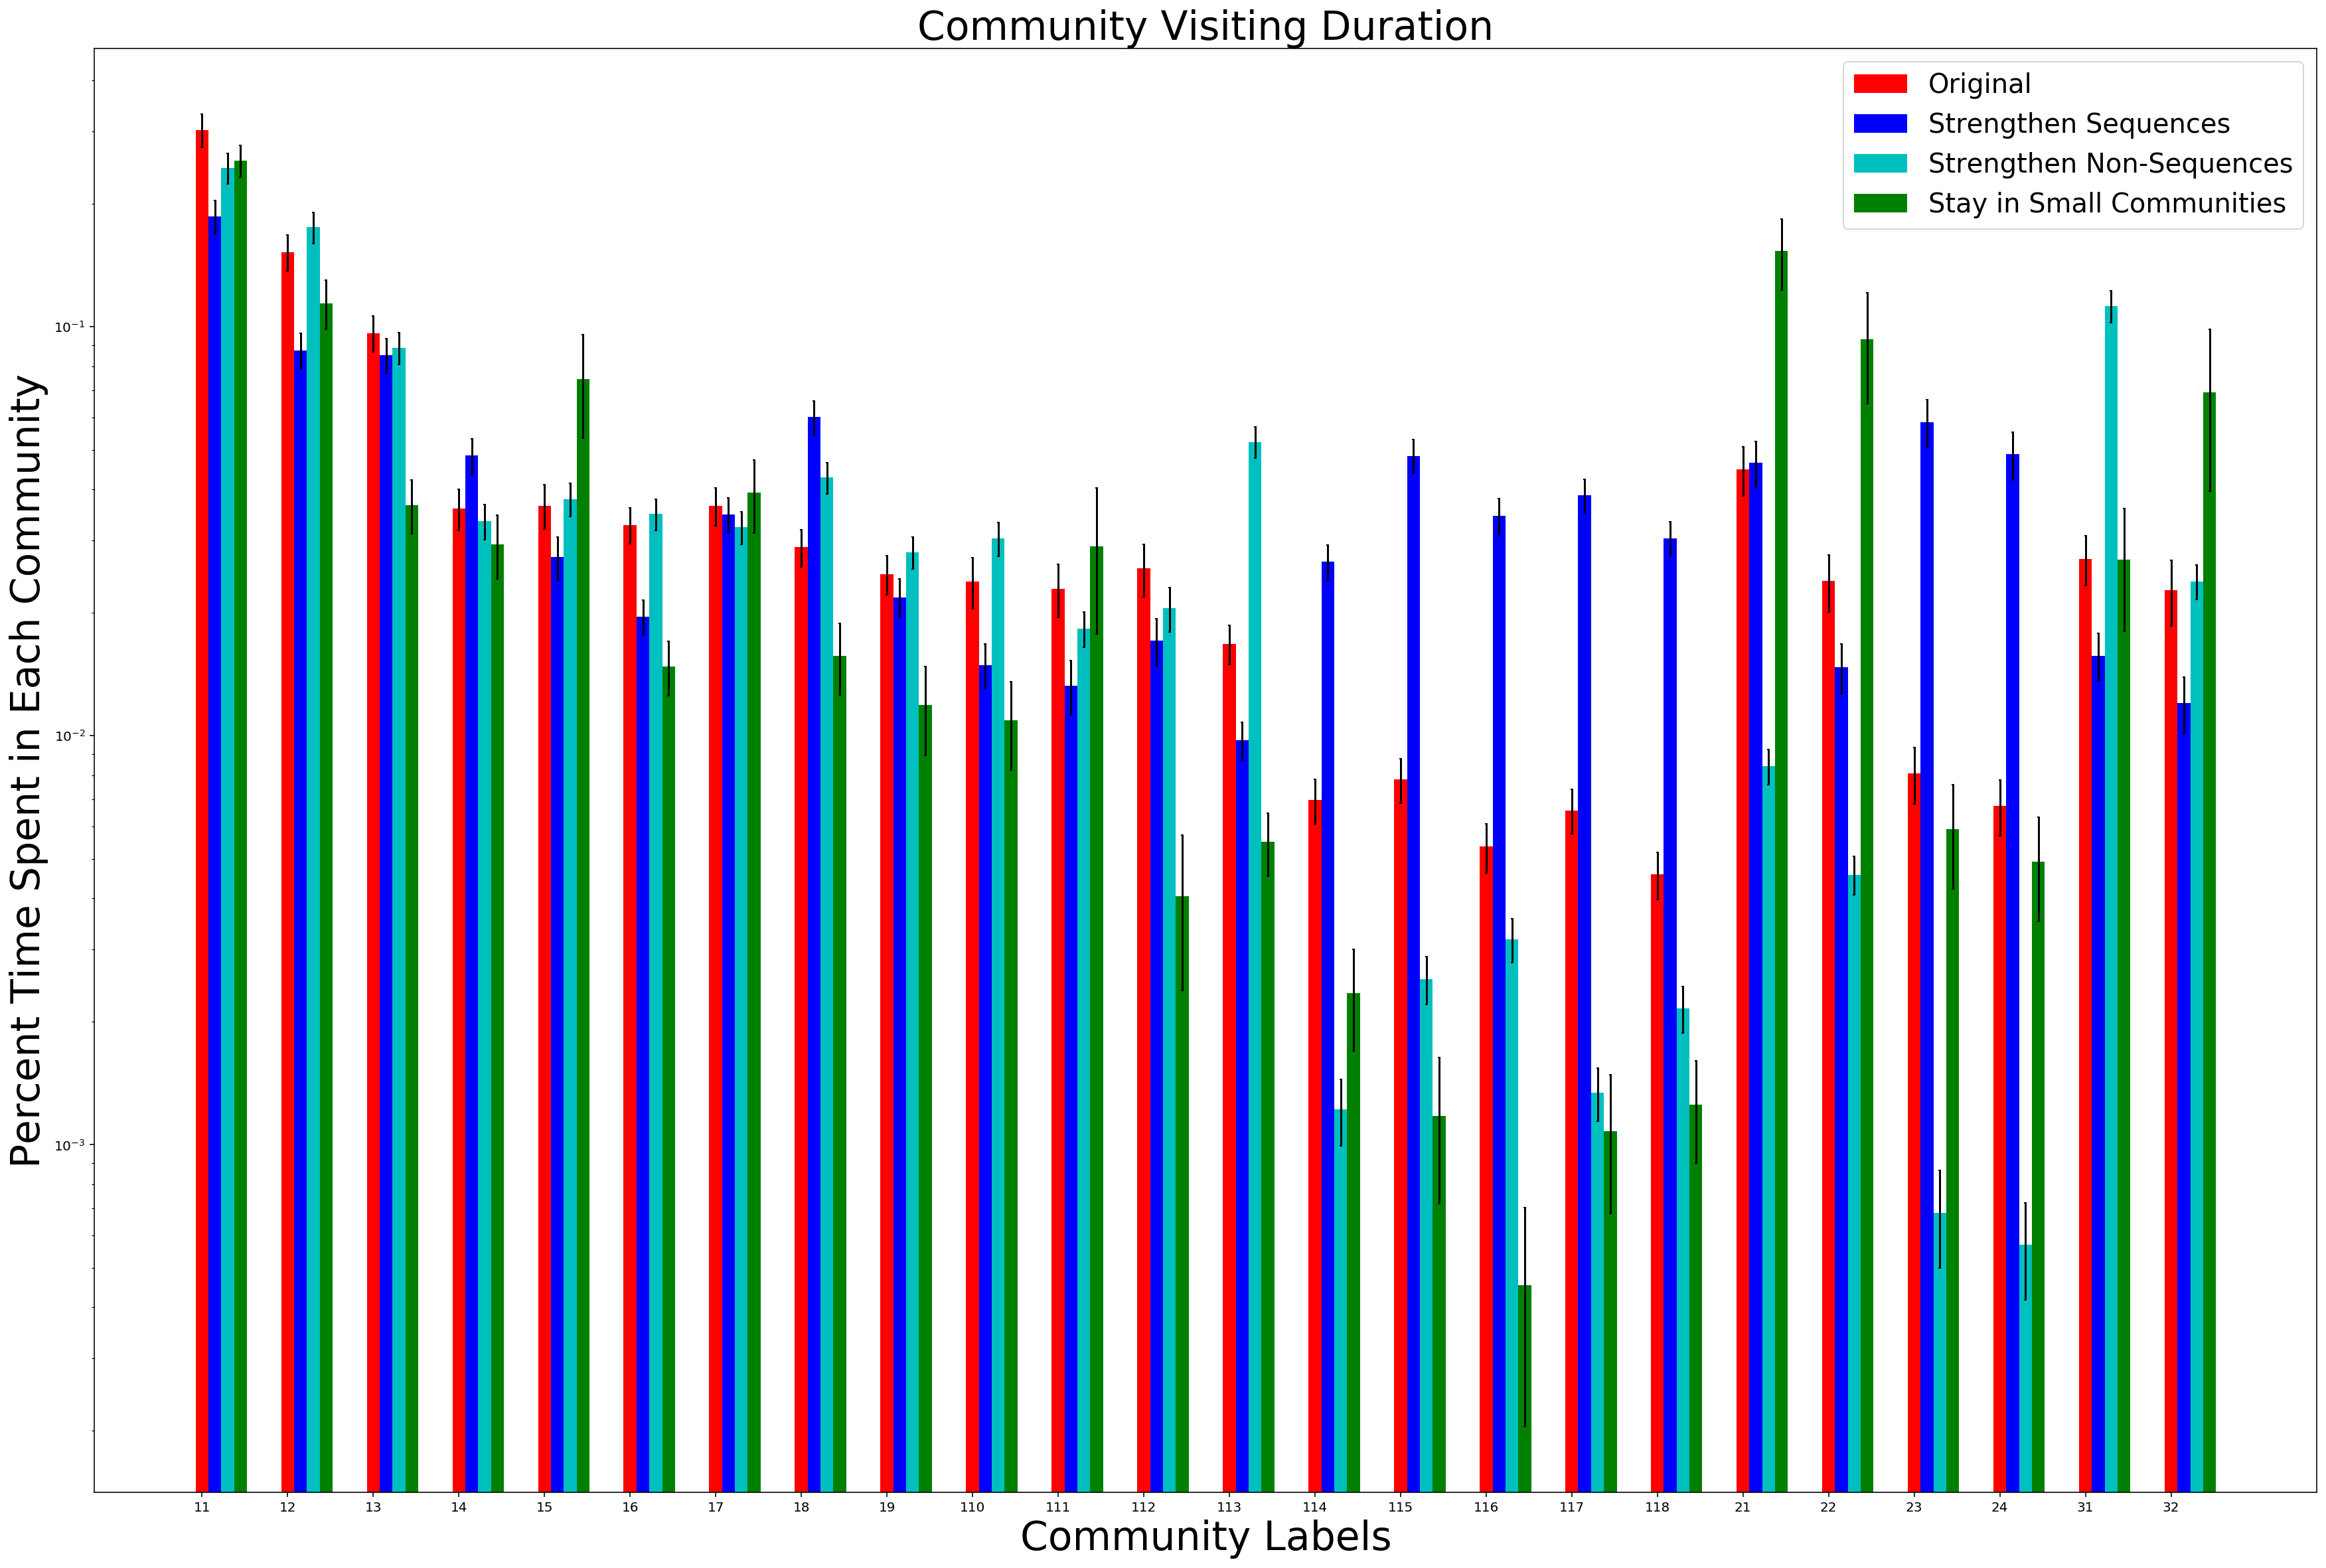

In [43]:
fig, ax = plt.subplots(figsize=(30,20))
ax.set_title("Community Visiting Duration", fontsize=30)
ax.set_xlabel("Community Labels", fontsize=30)
ax.set_ylabel("Percent Time Spent in Each Community", fontsize=30)
#ax = fig.add_axes([0,0,1,1])


cat = section_time_graph2[0]
print(cat)
x = np.arange(len(cat))
ax.set_xticks(x)
ax.set_xticklabels(cat)

time_og_small = section_time_graph_small[1]/np.sum(section_time_graph_small[1])
time_og_small_err = section_time_graph_small[2]/np.sum(section_time_graph_small[1])

time_comp2 = section_time_graph2[1]/np.sum(section_time_graph2[1])
time_comp_2_err = section_time_graph2[2]/np.sum(section_time_graph2[1])

time_comp3 = section_time_graph3[1]/np.sum(section_time_graph3[1])
time_comp_3_err = section_time_graph3[2]/np.sum(section_time_graph3[1])

time_comp5 = section_time_graph5[1]/np.sum(section_time_graph5[1])
time_comp_5_err = section_time_graph5[2]/np.sum(section_time_graph5[1])
#ax = fig.add_axes([0,0,1,1])
ax.bar(x + 0.00, time_og_small, color = 'r', width = 0.15, label = "Original", yerr=time_og_small_err, capsize=1 )
ax.bar(x + 0.15, time_comp2, color = 'b', width = 0.15, label = "Strengthen Sequences", yerr= time_comp_2_err, capsize=1 )
ax.bar(x + 0.30, time_comp3, color = 'c', width = 0.15, label = "Strengthen Non-Sequences", yerr= time_comp_3_err, capsize=1)
ax.bar(x + 0.45, time_comp5, color = 'g', width = 0.15, label = "Stay in Small Communities", yerr= time_comp_5_err, capsize=1)
ax.legend(fontsize=20)
ax.set_yscale('log')
plt.savefig("../figures/rn_timediff_smallcom.pdf")